In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
#from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
attrition = pd.read_csv('input/WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


As evinced from the dataset, our target column with which we can point our model to train on would be the **"Attrition"** column.

Furthermore, we see that we have a mix of numerical and categorical data types. Let us quickly carry our some simple data completeness checks to see if there are nulls or infinite values in the data

## Data quality checks

To look for any null values, we can just invoke the isnull call as follows

In [3]:
# Looking for NaN
display(attrition.isnull().any())

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [4]:

description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in attrition.columns:
    obs = attrition[col].size
    p_nan = round(attrition[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({attrition[col].isna().sum()}/{obs})'
    dtype = 'categorical' if attrition[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(attrition[col].unique())} labels' if dtype == 'categorical' else f'{attrition[col].min()}-{attrition[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

numerical.remove('EmployeeCount')
numerical.remove('StandardHours')
pd.set_option('display.max_columns', 100)
display(description)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
observations(rows),1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
percent missing,0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,18-60,2 labels,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-1,1-2068,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,1 labels,2 labels,11-25,3-4,1-4,80-80,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17


## Distribution of the dataset

Generally one of the first few steps in exploring the data would be to have a rough idea of how the features are distributed with one another.

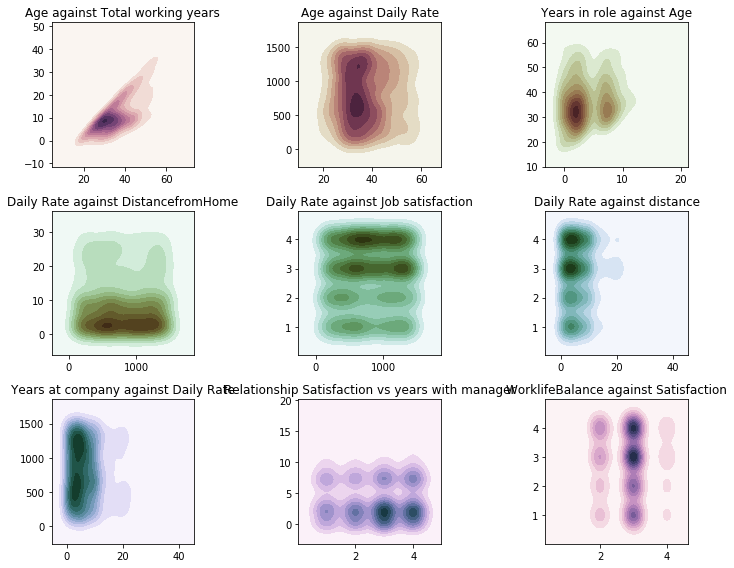

In [5]:
# Plotting the KDEplots
f, axes = plt.subplots(3, 3, figsize=(10, 8), 
                       sharex=False, sharey=False)

# Defining our colormap scheme
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=axes[0,0])
axes[0,0].set( title = 'Age against Total working years')

cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = 'Age against Daily Rate')

cmap = sns.cubehelix_palette(start=0.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,2])
axes[0,2].set( title = 'Years in role against Age')

cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set( title = 'Daily Rate against DistancefromHome')

cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set( title = 'Daily Rate against Job satisfaction')

cmap = sns.cubehelix_palette(start=1.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,2])
axes[1,2].set( title = 'Daily Rate against distance')

cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)
# Generate and plot
x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,0])
axes[2,0].set( title = 'Years at company against Daily Rate')

cmap = sns.cubehelix_palette(start=2.333333333333, light=1, as_cmap=True)
# Generate and plot
x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,1])
axes[2,1].set( title = 'Relationship Satisfaction vs years with manager')

cmap = sns.cubehelix_palette(start=2.666666666667, light=1, as_cmap=True)
# Generate and plot
x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[2,2])
axes[2,2].set( title = 'WorklifeBalance against Satisfaction')

f.tight_layout()

In [6]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
attrition["Attrition_numerical"] = attrition["Attrition"].apply(lambda x: target_map[x])

In [7]:
#  creating a list of only numerical values
num_vars = [var for var in attrition.columns if attrition[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))

Number of numerical variables:  27


In [8]:
num_vars

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_numerical']

In [9]:
for x in {'Attrition_numerical', 'EmployeeCount', 'StandardHours'}:
    num_vars.remove(x) 

## Correlation of Features

In [10]:
len(num_vars)

24

In [11]:
# creating a list of only numerical values
data = [
    go.Heatmap(
        z= attrition[num_vars].astype(float).corr().values, # Generating the Pearson correlation
        x=attrition[num_vars].columns.values,
        y=attrition[num_vars].columns.values,
        colorscale='Viridis',
        reversescale = False,
#         text = True ,
        opacity = 1.0
        
    )
]


layout = go.Layout(
    title='Pearson Correlation of numerical features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [12]:
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break
            
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In [17]:
import time
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sci
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

In [18]:
lgb_data = attrition.copy()
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)
lgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)

y_df = lgb_data['Attrition'].reset_index(drop=True)
x_df = lgb_data.drop(columns='Attrition')
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def lgb_objective(space, early_stopping_rounds=50):
    
    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']), 
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )
    
    lgbm.fit(train_x, train_y, 
            eval_set = [(train_x, train_y), (test_x, test_y)],
            early_stopping_rounds = early_stopping_rounds,
            eval_metric = 'auc',
            verbose = False)
    
    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(train_x)[:,1]
    
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)  

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

In [19]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0), 
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )


100%|██████████| 150/150 [00:16<00:00,  8.92it/s, best loss: 0.0]


In [20]:
lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

{'model': 'LightGBM',
 'parameter search time': '0:00:16.805000',
 'accuracy': 0.871,
 'test auc score': 1.0,
 'training auc score': 1.0,
 'parameters': {'colsample_bytree': 0.9248467636827036,
  'feature_fraction': 0.5770253385082582,
  'learning_rate': 0.0011960065900787143,
  'max_depth': 3.0,
  'min_split_gain': 0.08643475886097207,
  'n_estimators': 350.0,
  'num_leaves': 59.0,
  'reg_alpha': 0.6416863148658184,
  'reg_lambda': 0.007792833879206262}}